In [5]:
import pandas as pd
import os
from datetime import datetime
from PIL import Image
from datetime import datetime, timedelta
import time as time_lib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import gaussian_kde
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

color0 = '#000000'
color1 = '#43519B'
color2 = '#7180D3'
color3='#C13557'
color4 = '#D37189'
color5 = '#018539'
color6 = '#50CD85'

sns.set(style="whitegrid")

In [6]:
def save_figure(filename):
    folder_path = 'C:\\Users\\Tee\\senior_project\\src\\figure_png_pdf_svg'
    formats = ['pdf', 'png', 'svg']
    for mat in formats:
        fig_path = os.path.join(folder_path, '{}_file'.format(mat) , '{}.{}'.format(filename,mat))
        plt.savefig(fig_path, format= mat, bbox_inches="tight", dpi =200)
        
def count_sample_k(df):
    nklow = len(df[df.k_bar<=0.3])
    nkmed = len(df[(df.k_bar>0.3) & (df.k_bar<=0.6)])
    nkhigh =  len(df[(df.k_bar>0.6)])
    return nklow, nkmed, nkhigh

def sep_clear(df):
    t = 0.9
    dklow = df[df.k_bar<t]
    dkhigh = df[(df.k_bar>=t)]
    return dklow, dkhigh

def single_model_eva(dz, name_model, base = 'I'):
    df = dz.copy()
    data = []
    N = len(df)
    i_mean = df[base].mean()
    df['basemodel'] = i_mean
    
    basemodel = mean_squared_error(df[base], df['basemodel'])
    
    MAE= mean_absolute_error(df[base],df[name_model])
    MSE = mean_squared_error(df[base],df[name_model])
    RMSE = np.sqrt(MSE)
    dy = df[name_model].values - df[base].values
    MBE = np.mean(dy)
    Rsq = 1- MSE/basemodel
    NMAE = MAE/i_mean*100
    NRMSE = RMSE/i_mean*100
    NMBE = MBE/i_mean*100
    SD = 100/i_mean/N*np.sqrt(N**2*MSE - np.sum(dy)**2)
    
    data.append({'MBE':MBE, 'NMBE':NMBE,
                 'MAE':MAE, 'NMAE':NMAE, 
                 'RMSE':RMSE, 'NRMSE':NRMSE, 
                 'Rsq':Rsq, 'i_mean':i_mean, 'SD':SD})
    
    df = pd.DataFrame(data)
    return df

def eva_table(df, name_model, base = 'I',):
    data = []
    dfnoon = df[(df.index.hour > 10) & (df.index.hour <=14)]
    dfnonnoon = df[~((df.index.hour > 10) & (df.index.hour <=14))]
    for i in range(len(name_model)):
        
        MAE= mean_absolute_error(df[base],df[name_model[i]])
        RMSE = np.sqrt(mean_squared_error(df[base],df[name_model[i]]))
        noon_MAE = mean_absolute_error(dfnoon[base],dfnoon[name_model[i]])
        noon_RMSE = np.sqrt(mean_squared_error(dfnoon[base],dfnoon[name_model[i]]))
        non_noon_MAE = mean_absolute_error(dfnonnoon[base],dfnonnoon[name_model[i]])
        non_noon_RMSE = np.sqrt(mean_squared_error(dfnonnoon[base],dfnonnoon[name_model[i]]))
        
        data.append({'Overall MAE':MAE, 'Overall RMSE':RMSE, 'MAE at noon':noon_MAE, 'RMSE at noon':noon_RMSE,
                    'MAE at non-noon':non_noon_MAE, 'RMSE at non-noon':non_noon_RMSE})
    df = pd.DataFrame(data)
    df.index = name_model
    return df

def group_table(df, name_model, base = 'I', score = 'MAE', by = None):
    dfh = df[['site_name',base]].copy()
    if by == None:
        by = [dfh.index.hour]

    if score == 'MAE':
        for i in range(len(name_model)):
            dfh[name_model[i]] = abs(df[base]-df[name_model[i]])
        return dfh.groupby(by=by).mean().reset_index()
    else:
        for i in range(len(name_model)):
            dfh[name_model[i]] = abs(df[base]-df[name_model[i]])**2
        return np.sqrt(dfh.groupby(by=by).mean()).reset_index()

# CI and k Scatter plot

In [8]:
DATA_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\dataset'
filename = 'DATASET_ch1_overview.csv'
#filename = 'separated_DATASET_cloudmask.csv'

In [9]:
df = pd.read_csv(os.path.join(DATA_FOLDER,filename), index_col='Datetime', parse_dates=['Datetime'])
df.dropna(inplace=True)
df

,site_name,I,Iclr,k,k_bar,HR,CI0,CI1,CI_1,CI_2,...,CI_16,CI_17,CI_18,CI_19,CI_20,CI_21,CI_22,CI_23,CI_24,CI_25
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-23 10:00:00+07:00,ISL001,805.9780,732.769967,1.099906,0.620564,10,0.498039,0.454902,0.615686,0.592157,...,0.549020,0.470588,0.505882,0.552941,0.588235,0.509804,0.501961,0.537255,0.560784,0.576471
2022-03-23 10:30:00+07:00,ISL001,512.6390,812.250731,0.631134,0.620564,10,0.439216,0.498039,0.478431,0.380392,...,0.509804,0.478431,0.439216,0.482353,0.545098,0.494118,0.454902,0.466667,0.572549,0.533333
2022-03-23 11:00:00+07:00,ISL001,494.7877,874.980215,0.565484,0.620564,11,0.576471,0.439216,0.603922,0.619608,...,0.486275,0.478431,0.525490,0.584314,0.576471,0.533333,0.513725,0.501961,0.552941,0.572549
2022-03-23 11:30:00+07:00,ISL001,314.8849,919.727489,0.342368,0.620564,11,0.666667,0.576471,0.407843,0.423529,...,0.576471,0.650980,0.682353,0.592157,0.603922,0.623529,0.694118,0.784314,0.745098,0.643137
2022-03-23 12:00:00+07:00,ISL001,297.7652,945.634812,0.314884,0.620564,12,0.882353,0.666667,0.658824,0.701961,...,0.874510,0.913725,0.905882,0.827451,0.725490,0.858824,0.890196,0.901961,0.788235,0.654902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-02 14:00:00+07:00,ISL022,309.9177,854.287175,0.362779,0.268058,14,0.737255,0.827451,0.760784,0.737255,...,0.784314,0.756863,0.752941,0.752941,0.768627,0.796078,0.788235,0.760784,0.764706,0.768627
2022-05-02 14:30:00+07:00,ISL022,390.1934,778.783600,0.501029,0.268058,14,0.772549,0.737255,0.749020,0.768627,...,0.784314,0.792157,0.788235,0.800000,0.796078,0.792157,0.803922,0.800000,0.807843,0.800000
2022-05-02 15:00:00+07:00,ISL022,204.8253,688.646819,0.297432,0.268058,15,0.764706,0.772549,0.729412,0.768627,...,0.682353,0.752941,0.721569,0.741176,0.807843,0.709804,0.698039,0.737255,0.733333,0.768627


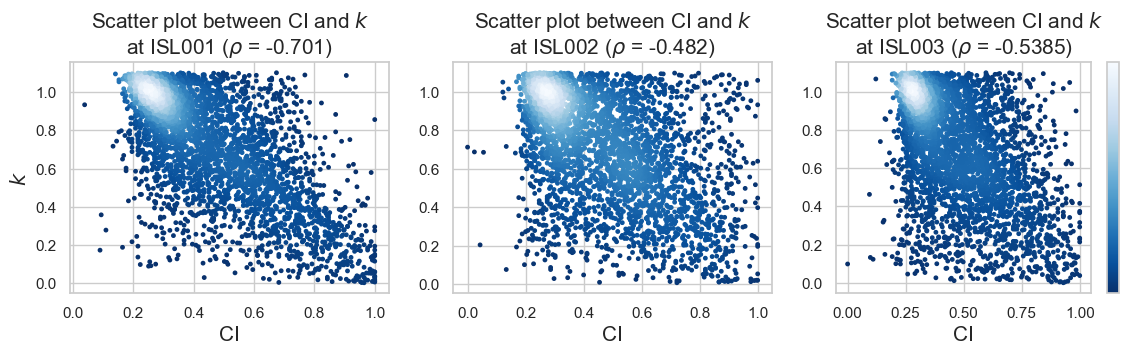

In [10]:
fig,ax=plt.subplots(1,3, figsize=(14,3))

for i in range(3):
    site = 'ISL00{}'.format(i+1)
    mask = (df.site_name==site) & (df.k <=1.1)
    
    X=df[mask].CI0
    Y=df[mask].k
    xy = np.vstack([X,Y])
    z = gaussian_kde(xy)(xy)
    cor = str(round(scipy.stats.pearsonr(X, Y)[0],4))
    sc= ax[i].scatter(x=X,y=Y,c=z,s=6,cmap='Blues_r')
    ax[i].set_title(r'Scatter plot between CI and $k$' +'\nat '+site+ r' ($\rho$ = '+cor+')',fontsize=15)
    ax[i].set_xlabel('CI',fontsize=15);
    if i == 0 :
        ax[i].set_ylabel(r'$k$',fontsize=15);
cbar = fig.colorbar(sc)
cbar.set_ticks([])
#save_figure('sc_cm')

In [7]:
DATA_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\dataset'
clearsky_df = pd.read_csv(os.path.join(DATA_FOLDER,'clearsky_data.csv'),parse_dates=['Datetime'],index_col='Datetime')
ims_df = pd.read_csv(os.path.join(DATA_FOLDER,'ims.csv'),parse_dates=['Datetime'],index_col='Datetime')
clearsky_df.index = clearsky_df.index.tz_convert('Asia/Bangkok')
ims_df.drop(columns=['Unnamed: 0'],inplace=True)

In [10]:
cidf = pd.read_csv(os.path.join(DATA_FOLDER,'ci_cloudmask.csv'),parse_dates=['Datetime'],index_col='Datetime')

In [13]:
q= ims_df.merge(clearsky_df,how='inner',on=['Datetime','site_name'])
begin = '2022-02-27'
end='2022-03-02'
q

,site_name,ims_wpm2,Iclr,am,zna
Datetime,,,,,
2022-02-05 06:00:00+07:00,ISL001,0.000000,0.000000,37.919608,-0.198615
2022-02-05 06:30:00+07:00,ISL001,0.512127,0.000000,37.919608,-0.077247
2022-02-05 07:00:00+07:00,ISL001,35.702560,2.107694,16.899972,0.044269
2022-02-05 07:30:00+07:00,ISL001,40.896990,63.506241,5.898027,0.163852
2022-02-05 08:00:00+07:00,ISL001,174.415800,169.815806,3.538561,0.279458
...,...,...,...,...,...
2023-02-05 16:00:00+07:00,ISL056,395.806100,422.623411,1.943479,0.513165
2023-02-05 16:30:00+07:00,ISL056,284.019300,311.010285,2.411189,0.412846
2023-02-05 17:00:00+07:00,ISL056,143.355000,195.181601,3.255669,0.304329


In [14]:
kt = q[q.site_name == 'ISL001'].loc[begin:end][['ims_wpm2','Iclr']].copy()
kt['k'] = kt.ims_wpm2/kt.Iclr
kt['CI']=cidf[cidf.site_name == 'ISL001'].loc[begin:end][['CI']]

C:\Users\Tee\AppData\Local\Temp\ipykernel_15828\3827853517.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  kt['CI']=cidf[cidf.site_name == 'ISL001'].loc[begin:end][['CI']]


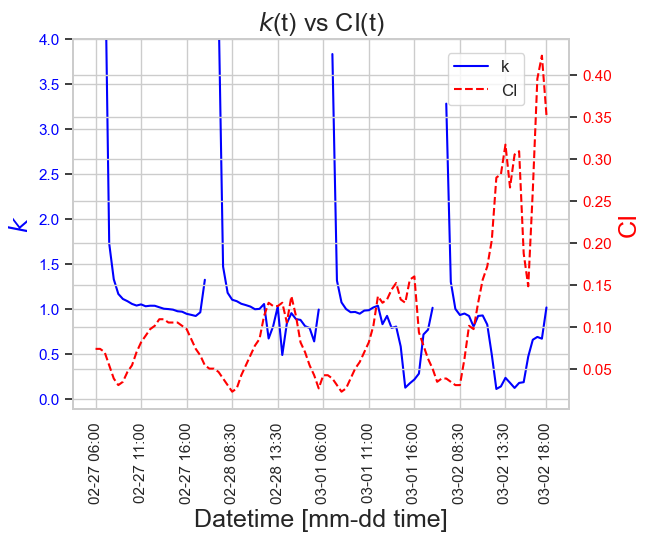

In [15]:
dd=[d for d in range(0,len(kt.k.values)+1,10)]

dd[-1] = dd[-1]-1
listt = []
for e in kt.index:
    listt.append(str(e)[5:16])
date = [listt[i] for i in dd]

fig, ax1 = plt.subplots()
ax1.set_xlabel('Datetime [mm-dd time]',fontsize=18)
ax1.set_ylim([-0.1,4])
ax1.set_ylabel(r'$k$', color='blue',fontsize=18)
ax1.set_xticks(dd,date,rotation = 'vertical');
ax1.plot(kt.k.values, '-',color='blue',label='k')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'red'
ax2.set_ylabel(r'CI', color=color,fontsize=18)  # we already handled the x-label with ax1
lns2 = ax2.plot(kt.CI.values,'--',color=color,label='CI')
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title(r'$k$(t) vs CI(t)', fontsize=18)
fig.legend(bbox_to_anchor=(0.83, 0.85), borderaxespad=0,fontsize=12)
#save_figure('plotk_t')

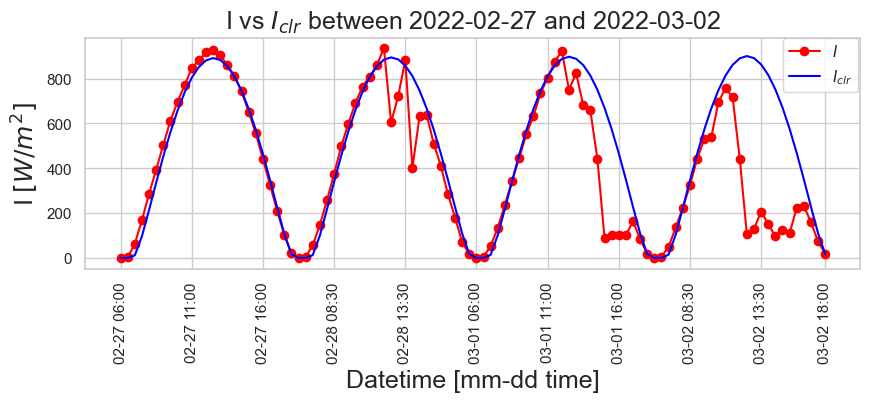

In [16]:
begin = '2022-02-27'
end='2022-03-02'
dd=[d for d in range(0,110,10)]
dd[-1] = 99
listt = []
for e in q[q.site_name == 'ISL001'].loc[begin:end].index:
    listt.append(str(e)[5:16])
date = [listt[i] for i in dd]
plt.figure(figsize=[10,3])

plt.plot(q[q.site_name == 'ISL001'].loc[begin:end][['ims_wpm2']].values,'-o',label=r'$I$',color='red')
plt.plot(q[q.site_name == 'ISL001'].loc[begin:end][['Iclr']].values,label=r'$I_{clr}$',color='blue')


plt.xticks(rotation = 'vertical');
plt.legend(bbox_to_anchor=(0.9, 1), borderaxespad=0)
plt.title(r'I vs $I_{clr}$ between '+begin+' and '+end,fontsize=18)
plt.xlabel('Datetime [mm-dd time]',fontsize=18)
plt.ylabel('I $[W/m^2]$',fontsize=18)
plt.xticks(dd,date);
#save_figure('IclrVSI')

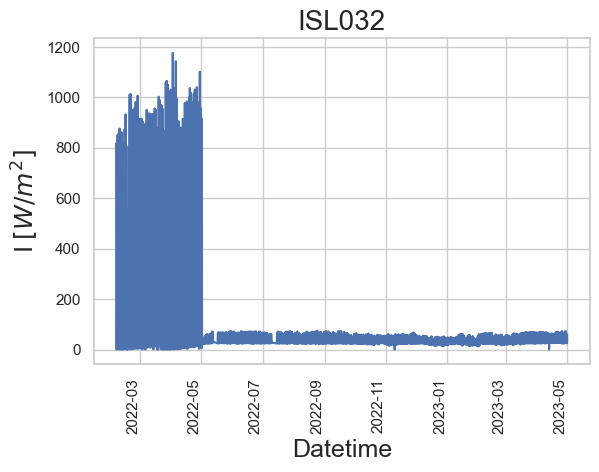

In [17]:
aa=ims_df[ims_df.site_name=='ISL032'].plot(legend=False)
aa.set_ylabel('I $[W/m^2]$',fontsize=18)
aa.set_xlabel('Datetime',fontsize=18)
aa.set_title('ISL032',fontsize=20)
plt.xticks(rotation='vertical');
#save_figure('ISL032')

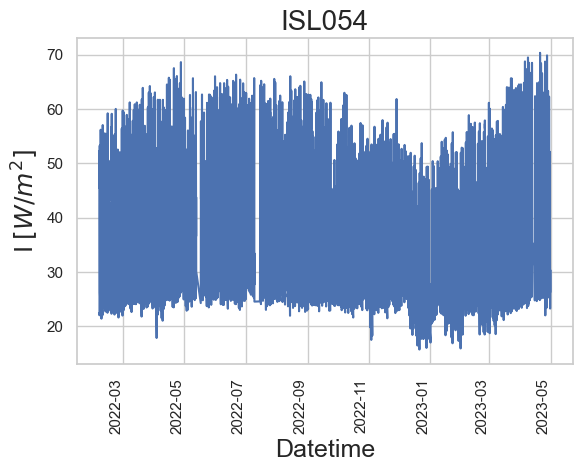

In [18]:
aa=ims_df[ims_df.site_name=='ISL054'].plot(legend=False)
aa.set_ylabel('I $[W/m^2]$',fontsize=18)
aa.set_xlabel('Datetime',fontsize=18)
aa.set_title('ISL054',fontsize=20)
plt.xticks(rotation='vertical');
#save_figure('ISL054')

In [19]:
c = clearsky_df[clearsky_df.site_name=='ISL001'].loc['2022-02-27':'2022-02-28']

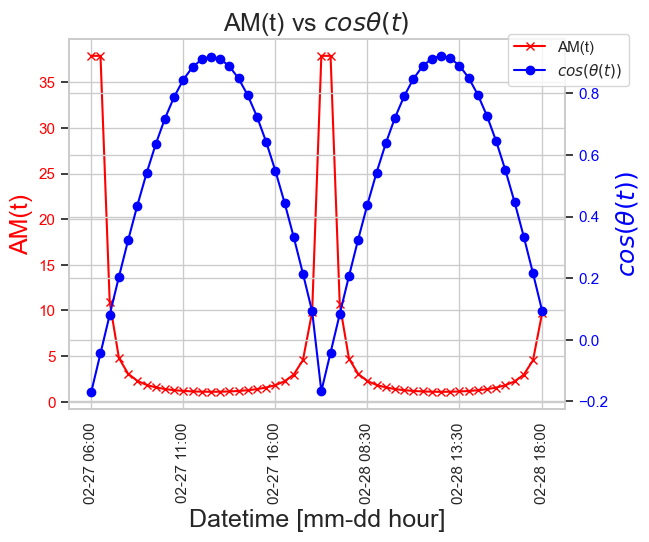

In [20]:
sns.set(style = 'whitegrid')
dd=[d for d in range(0,len(c.am.values)+1,10)]

dd[-1] = dd[-1]-1
listt = []
for e in c.index:
    listt.append(str(e)[5:16])
date = [listt[i] for i in dd]

fig, ax1 = plt.subplots()
color = 'red'
ax1.set_xlabel('Datetime [mm-dd hour]',fontsize=18)
ax1.set_ylabel('AM(t)', color=color,fontsize=18)
lns1= ax1.plot(c.am.values,'-x',color=color,label='AM(t)')
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(dd,date,rotation = 'vertical');
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel(r'$cos(\theta(t))$', color=color,fontsize=18)  # we already handled the x-label with ax1
lns2 = ax2.plot(c.zna.values,'-o',color=color,label=r'$cos(\theta(t))$')
ax2.tick_params(axis='y', labelcolor=color)
plt.title(r'AM(t) vs $cos\theta(t)$',fontsize=18)

fig.legend(bbox_to_anchor=(1,0.89), borderaxespad=0)
#save_figure('AMvsZNA')

# V1V2 Validation

In [11]:
DATA_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\dataset'
IHAT_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\estimation_irradiance'

In [13]:
cidf= pd.read_csv(os.path.join(DATA_FOLDER,'ci_cloudmask.csv'),parse_dates=['Datetime'],index_col='Datetime')

In [14]:
IP1 = pd.read_csv(os.path.join(IHAT_FOLDER,'ihat_modelv1.csv'),parse_dates=['Datetime'],index_col='Datetime')
IP2 = pd.read_csv(os.path.join(IHAT_FOLDER,'ihat_modelv2.csv'),parse_dates=['Datetime'],index_col='Datetime')

In [15]:
ALL1= IP1.copy()
ALL1['MAE'] = abs(ALL1.ihat_wpm2 -ALL1.ims_wpm2)
ALL1 = ALL1.MAE.mean()
ALL2 = IP2.copy()
ALL2['MAE'] = abs(ALL2.ihat_wpm2 -ALL2.ims_wpm2)
ALL2 = ALL2.MAE.mean()
print('P1 MAE: ' + str(ALL1) )
print('P2 MAE: ' + str(ALL2) )

P1 MAE: 132.87022704791883
P2 MAE: 118.64358137107365


In [16]:
NOON1 = IP1[((IP1.index.hour>10) &(IP1.index.hour<=14))].copy()
NOON1['MAE'] = abs(NOON1.ihat_wpm2 -NOON1.ims_wpm2)
NOON1 = NOON1.MAE.mean()
NOON2 = IP2[((IP2.index.hour>10) &(IP2.index.hour<=14))].copy()
NOON2['MAE'] = abs(NOON2.ihat_wpm2 -NOON2.ims_wpm2)
NOON2 = NOON2.MAE.mean()
print('P1 MAE at noon: ' + str(NOON1) )
print('P2 MAE at noon: ' + str(NOON2) )

P1 MAE at noon: 202.52790493778645
P2 MAE at noon: 145.57106267799762


In [17]:
NONNOON1 = IP1[~((IP1.index.hour>10) &(IP1.index.hour<=14))].copy()
NONNOON1['MAE'] = abs(NONNOON1.ihat_wpm2 -NONNOON1.ims_wpm2)
NONNOON1 = NONNOON1.MAE.mean()
NONNOON2 = IP2[~((IP2.index.hour>10) &(IP2.index.hour<=14))].copy()
NONNOON2['MAE'] = abs(NONNOON2.ihat_wpm2 -NONNOON2.ims_wpm2)
NONNOON2 = NONNOON2.MAE.mean()
print('P1 MAE at nonnoon: ' + str(NONNOON1) )
print('P2 MAE at nonnoon: ' + str(NONNOON2) )

P1 MAE at nonnoon: 100.15543288268745
P2 MAE at nonnoon: 102.95799617154562


In [18]:
## by_hour all site
by_hour1 = IP1.copy()
by_hour1['MAE'] = abs(by_hour1.ihat_wpm2 -by_hour1.ims_wpm2)
by_hour1 = by_hour1.groupby(by=[by_hour1.index.hour]).mean()
by_hour1['nMAE'] =  by_hour1.MAE/by_hour1.ims_wpm2.mean()*100

by_hour2 = IP2.copy()
by_hour2['MAE'] = abs(by_hour2.ihat_wpm2 -by_hour2.ims_wpm2)
by_hour2 = by_hour2.groupby(by=[by_hour2.index.hour]).mean()
by_hour2['nMAE'] =  by_hour2.MAE/by_hour2.ims_wpm2.mean()*100

by_hour = pd.merge(by_hour1,by_hour2,on=['Datetime'],how='inner')
print('average I of v1: '+str(by_hour1.ims_wpm2.mean()))
print('average I of v2: '+str(by_hour2.ims_wpm2.mean()))

average I of v1: 393.2274860553684
average I of v2: 453.2267408169067


In [19]:
by_hour.reset_index(inplace = True)

Text(0, 0.5, 'NMAE $[\\%]$')

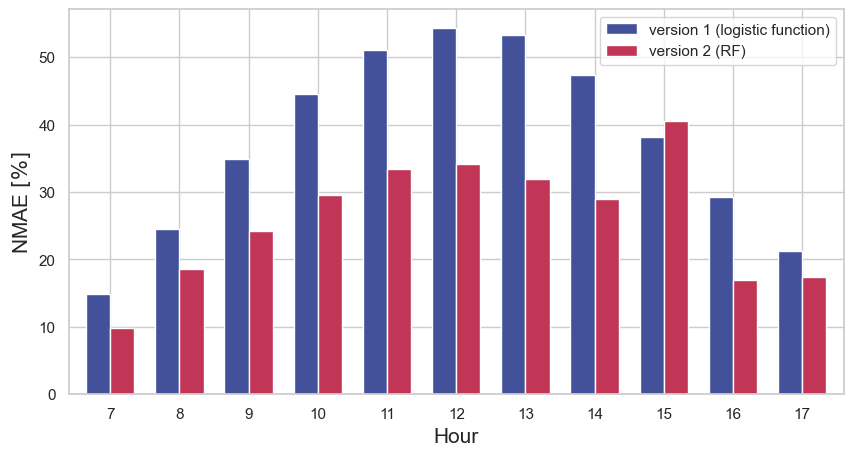

In [20]:
sns.set(style="whitegrid")
color1 = '#43519B'
color2 = '#C13557'
ax= by_hour.plot(x="Datetime", y=["nMAE_x","nMAE_y"], kind="bar",color=[color1,color2],rot=0,label=['version 1 (logistic function)','version 2 (RF)'],width=0.7,figsize=(10,5))
plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'NMAE $[\%]$',fontsize=15)
#save_figure('NMAE_HOURLY_P1_2')

Text(0, 0.5, 'MAE $[W/m^2]$')

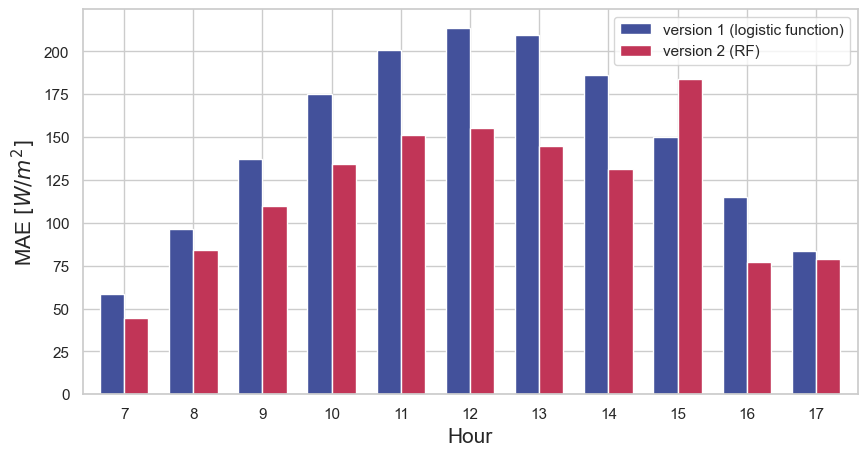

In [21]:
color1 = '#43519B'
color2 = '#C13557'
ax= by_hour.plot(x="Datetime", y=["MAE_x","MAE_y"], kind="bar",color=[color1,color2],rot=0,label=['version 1 (logistic function)','version 2 (RF)'],width=0.7,figsize=(10,5))
plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'MAE $[W/m^2]$',fontsize=15)
#save_figure('MAE_HOURLY_P1_2')

In [32]:
name_model = ['ihat_wpm2']

df = group_table(IP1, name_model, base='ims_wpm2', by=[IP1.index.date,'site_name'])
df.rename(columns={'level_0':'date'}, inplace=True)
df['n_data_point'] = IP1[['site_name','ims_wpm2']].groupby(by=[IP1.index.date,'site_name']).count().ims_wpm2.values

df_bad = df[df.n_data_point>17].nlargest(3,'ihat_wpm2')
df_best = df[df.n_data_point>17].nsmallest(3,'ihat_wpm2')

bad_date1 = [str(d) for d in df_bad.date.to_list()]
best_date1 = [str(d) for d in df_best.date.to_list()]
bad_site1 = df_bad.site_name.to_list()
best_site1 = df_best.site_name.to_list()

In [33]:
ci = cidf[['site_name','CI']]
ci = ci.between_time('7:00','17:30')
ci = ci.sort_values(by=['Datetime','site_name'])
ci.head()

,site_name,CI
Datetime,,
2022-02-05 07:00:00+07:00,ISL001,0.223529
2022-02-05 07:00:00+07:00,ISL002,0.141176
2022-02-05 07:00:00+07:00,ISL003,0.113725
2022-02-05 07:00:00+07:00,ISL004,0.129412
2022-02-05 07:00:00+07:00,ISL005,0.137255


In [34]:
name_model = ['ihat_wpm2']
IP22 = pd.merge(IP2, ci, on = ['Datetime', 'site_name'], how = 'inner')

df = group_table(IP22, name_model, base='ims_wpm2', by=[IP22.index.date,'site_name'])
df.rename(columns={'level_0':'date'}, inplace=True)
df['n_data_point'] = IP22[['site_name','ims_wpm2']].groupby(by=[IP22.index.date,'site_name']).count().ims_wpm2.values

df_bad = df[df.n_data_point>17].nlargest(4,'ihat_wpm2').iloc[1:]
df_best = df[df.n_data_point>17].nsmallest(3,'ihat_wpm2')

bad_date2 = [str(d) for d in df_bad.date.to_list()]
best_date2 = [str(d) for d in df_best.date.to_list()]
bad_site2 = df_bad.site_name.to_list()
best_site2 = df_best.site_name.to_list()

C:\Users\Tee\AppData\Local\Temp\ipykernel_15828\524652440.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k].set_xticklabels(['07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00']);
C:\Users\Tee\AppData\Local\Temp\ipykernel_15828\524652440.py:42: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=['I',r'$\hat{I}}$'], fontsize=20)


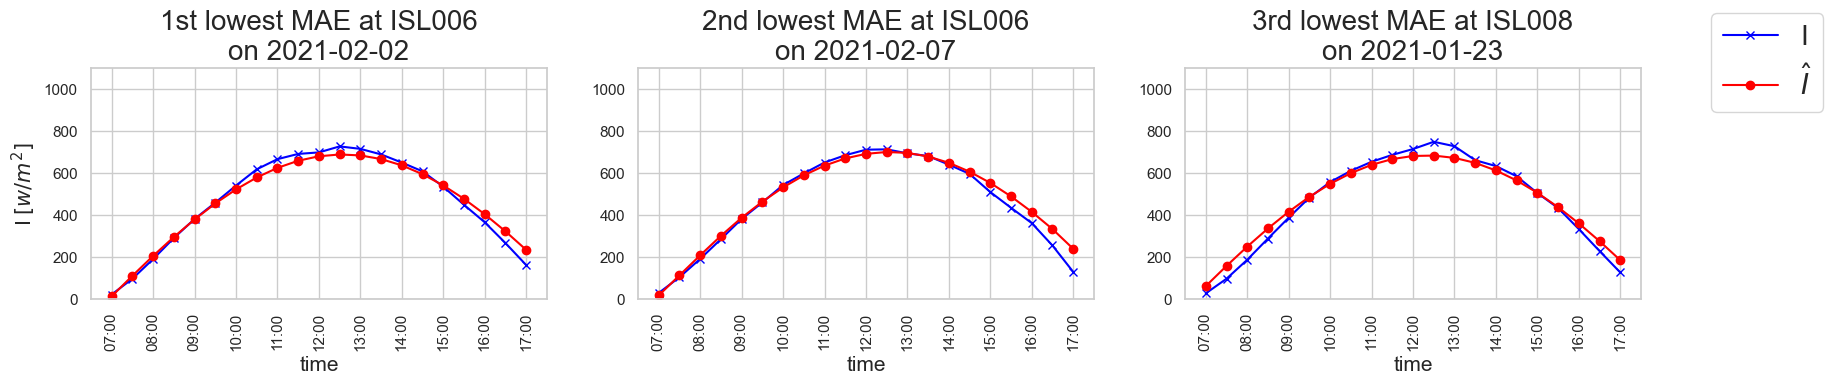

In [35]:
i=  1 # rank
j =  1 # version
filenames = {'highest': ['v1_highest', 'v2_highest'] , 'lowest': ['v1_lowest', 'v2_lowest']}
model_n = ['logistic regression','random forest']
rank = ['highest','lowest']
site = {'highest':[bad_site1,bad_site2],'lowest':[best_site1,best_site2]}
date = {'highest':[bad_date1, bad_date2],
       'lowest':[best_date1, best_date2]}
j = j-1
ggg = ['1st ','2nd ','3rd ']
####################################
fig,ax=plt.subplots(1,3, figsize=(20,3))
for k in range(3):
    
    plt.subplot(1,3,k+1)
    
    if j==1:
        ee1 = IP2[IP2.site_name==site[rank[i]][j][k]].loc[date[rank[i]][j][k]]
    else:
         ee1 = IP1[IP1.site_name==site[rank[i]][j][k]].loc[date[rank[i]][j][k]].between_time('7:00','17:00')
    
    l1=plt.plot(ee1.ims_wpm2,'-x',color='blue')
    plt.plot(ee1.ihat_wpm2,'-o',color='red')

    plt.xlabel('time',fontsize=15)
    plt.xticks(rotation = 'vertical');
    
    if k ==0 :
        plt.ylabel(r'I $[w/m^2]$',fontsize=15)
    plt.title(ggg[k]+rank[i]+' MAE at '+site[rank[i]][j][k]+ '\non '+date[rank[i]][j][k],fontsize=20)
    ax[k].set_xticklabels(['07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00']);
    ax[k].set_ylim(0,1100)
    if j ==1:
        cc = ci[ci.site_name==site[rank[i]][j][k]].loc[date[rank[i]][j][k]]
        ax2 = ax[k].twinx()
    
        if k ==2:
            ax2.set_ylabel(r'$CI$', color='green')  
        lns2 = ax2.plot(cc.CI, '--',color='green',label='CI')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.set_ylim(0,1)
fig.legend(l1, labels=['I',r'$\hat{I}}$'], fontsize=20)

if j == 1:
    ax2.legend(lns2, labels=['CI'],fontsize=17, bbox_to_anchor=(1.4, 0.7) , borderaxespad=0)
#save_figure(filenames[rank[i]][j])

# Proposed Model validation

In [22]:
IHAT_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\estimation_irradiance'
CMTREE_FILE = 'Ihat_cmTree.csv'
OVTREE_FILE = 'Ihat_ovTree.csv'
CMCNN_FILE = 'Ihat_1layerCNN.csv'
OVCNN_FILE = 'Ihat_2layerCNN.csv'
PHASE2_FILE = 'ihat_modelv2.csv'
REGRESS_FILE = 'ihat_cmRegress.csv'

In [32]:
df_cm_tree = pd.read_csv(os.path.join(IHAT_FOLDER,CMTREE_FILE),parse_dates=['Datetime'],index_col='Datetime')
df_ov_tree = pd.read_csv(os.path.join(IHAT_FOLDER,OVTREE_FILE),parse_dates=['Datetime'],index_col='Datetime')

df_cm_cnn = pd.read_csv(os.path.join(IHAT_FOLDER,CMCNN_FILE),parse_dates=['datetime'],index_col='datetime')
df_ov_cnn = pd.read_csv(os.path.join(IHAT_FOLDER,OVCNN_FILE),parse_dates=['datetime'],index_col='datetime')

df_cm_regress = pd.read_csv(os.path.join(IHAT_FOLDER,REGRESS_FILE),parse_dates=['Datetime'],index_col='Datetime')

In [33]:
df_cm_cnn.index.name = 'Datetime'
df_cm_cnn.index = df_cm_cnn.index.tz_localize('Asia/Bangkok')
df_cm_cnn.rename(columns = {'site':'site_name'}, inplace = True)

In [34]:
df_ov_cnn.index.name = 'Datetime'
df_ov_cnn.index = df_ov_cnn.index.tz_localize('Asia/Bangkok')
df_ov_cnn.rename(columns = {'site':'site_name'}, inplace = True)

In [35]:
dfcm = pd.merge(df_cm_tree, df_cm_cnn.drop(columns=['I']), how='inner', on=['Datetime','site_name'])
dfcm = pd.merge(dfcm, df_cm_regress.drop(columns=['I']), how='inner', on=['Datetime','site_name'])
dfov = pd.merge(df_ov_tree, df_ov_cnn.drop(columns=['I']), how='inner', on=['Datetime','site_name'])

In [36]:
dfcm.head()

,CI0,site_name,I,yXGB,yRF,I_Cloud2Kv1,I_Cloud2Kv2,I_Cloud2Kv3,I_Cloud2Kv4,I_Cloud2Iv1,I_Cloud2Iv2,I_Cloud2Iv3,linear,poly
Datetime,,,,,,,,,,,,,,
2022-03-28 11:00:00+07:00,0.129412,ISL001,913.0125,738.52990,769.481152,866.736070,837.388045,853.130871,843.355069,826.38336,812.8302,878.17630,761.467627,759.682233
2022-03-28 11:30:00+07:00,0.145098,ISL001,884.1139,741.86487,742.835996,894.742967,821.300916,878.561160,827.920017,890.33360,810.0137,906.54030,785.840251,771.950392
2022-03-28 12:00:00+07:00,0.160784,ISL001,987.1979,788.63120,735.260072,617.224660,623.754477,593.940754,511.826420,710.51560,680.7993,679.81134,795.125781,770.161851
2022-03-28 12:30:00+07:00,0.184314,ISL001,874.7495,702.28687,689.634019,674.146505,732.558333,781.571881,672.444465,786.75680,783.1002,815.69104,784.416616,747.302378
2022-03-28 13:00:00+07:00,0.196078,ISL001,824.3415,659.87317,606.903836,744.502663,671.532853,718.900905,640.942682,761.56960,745.0072,730.56810,766.555142,725.710912


In [37]:
dfov.head()

,CI0,site_name,I,yXGB,yRF,I_Cloud2Kv1,I_Cloud2Kv2,I_Cloud2Kv3,I_Cloud2Kv4,I_Cloud2Iv1,I_Cloud2Iv2,I_Cloud2Iv3
Datetime,,,,,,,,,,,,
2022-04-03 09:00:00+07:00,0.725490,ISL001,81.20869,242.96356,242.605641,258.807996,258.285451,222.058373,239.094390,178.26047,155.66394,215.70584
2022-04-03 11:00:00+07:00,0.705882,ISL001,698.68740,468.80856,471.300791,477.957919,395.100438,382.814690,442.312208,493.16086,473.23390,519.37030
2022-04-03 13:00:00+07:00,0.458824,ISL001,1051.06700,753.43620,764.722103,753.403647,754.652057,730.726513,662.065699,727.38650,679.36140,737.05493
2022-04-03 15:00:00+07:00,0.698039,ISL001,174.96450,375.41205,329.822118,335.769875,327.626596,281.153299,316.437368,280.78775,303.14352,333.46900
2022-04-14 08:00:00+07:00,0.243137,ISL001,372.27970,390.37120,383.579973,366.587924,365.038920,348.014212,336.260805,417.02860,405.98035,420.70166


In [38]:
name_model = ['linear','poly','yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
eva_table(dfcm, name_model, base = 'I').round(2).iloc[:, [0,2,4]]

,Overall MAE,MAE at noon,MAE at non-noon
linear,134.59,162.30,109.86
poly,130.31,155.21,108.09
yXGB,120.16,144.57,98.37
yRF,116.72,140.92,95.12
I_Cloud2Kv2,122.66,146.61,101.29
I_Cloud2Iv2,119.00,142.99,97.60


In [39]:
name_model = ['yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
eva_table(dfov, name_model, base='I')

,Overall MAE,Overall RMSE,MAE at noon,RMSE at noon,MAE at non-noon,RMSE at non-noon
yXGB,106.835019,149.029239,126.801941,173.005162,88.953725,123.673522
yRF,104.135005,145.748828,123.990568,169.625876,86.353437,120.412069
I_Cloud2Kv2,106.854941,153.218092,126.519408,179.387934,89.244510,125.222726
I_Cloud2Iv2,101.417661,148.903979,121.249767,174.304995,83.657102,121.737875


In [40]:
name_model = ['linear','poly','yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
q = group_table(dfcm, name_model, base = 'I').drop(columns=['I'])
q

,Datetime,linear,poly,yXGB,yRF,I_Cloud2Kv2,I_Cloud2Iv2
0,8,78.123232,83.070592,71.606157,69.475704,75.581886,71.652967
1,9,112.899957,110.671018,99.363278,96.410923,101.804644,98.954190
2,10,137.943064,129.243770,117.989331,114.852827,120.368442,117.296047
3,11,161.703458,151.661983,140.154914,135.569784,141.704962,138.919431
4,12,170.777332,161.953693,149.081442,146.439777,152.864109,148.608837
5,13,168.355948,161.722005,151.635262,147.568839,152.989547,150.412674
6,14,148.002760,145.233155,137.174595,133.896486,138.632515,133.746383
7,15,118.876024,118.608084,111.797428,107.556074,114.171852,110.249161
8,16,93.121378,89.543398,83.396497,79.184354,87.350386,81.780003


Text(0.5, 1.0, 'Hourly MAE of 4 models')

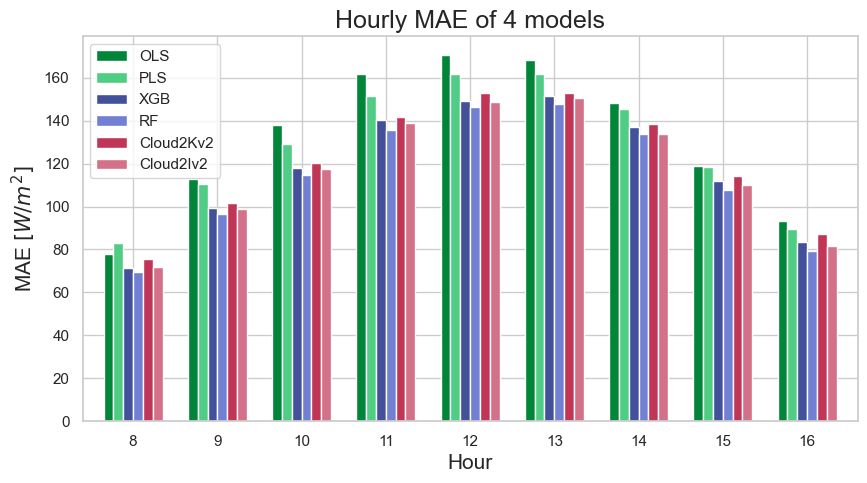

In [50]:
sns.set(style="whitegrid")
color1 = '#43519B'
color2 = '#7180D3'
color3='#C13557'
color4 = '#D37189'
color5 = '#018539'
color6 = '#50CD85'
label = ['OLS','PLS','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
ax= q.plot(x='Datetime', y=name_model, kind="bar",color=[color5, color6, color1,color2,color3,color4],label=label, rot=0,width=0.7,figsize=(10,5))

plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'MAE $[W/m^2]$',fontsize=15)
plt.title('Hourly MAE of 4 models',fontsize=18)

In [51]:
name_model = ['yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
q = group_table(dfov, name_model, base = 'I').drop(columns=['I'])
q

,Datetime,yXGB,yRF,I_Cloud2Kv2,I_Cloud2Iv2
0,8,64.529877,62.401447,68.543033,61.796771
1,9,85.168506,82.147293,87.957547,80.813511
2,10,104.946130,101.649468,108.332627,102.710694
3,11,118.670868,116.259952,121.052781,116.077190
4,12,127.449744,125.639765,129.182459,124.499429
5,13,133.831936,129.365423,133.327165,126.749581
6,14,126.925594,124.427203,122.117124,117.327822
7,15,103.738998,102.106934,97.512016,94.304333
8,16,82.291171,78.973218,78.080602,72.926678


Text(0.5, 1.0, 'Hourly MAE of 4 models')

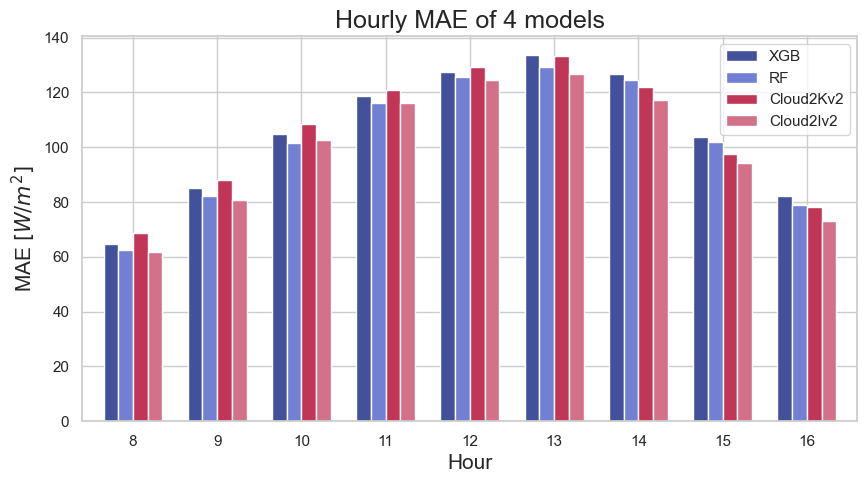

In [52]:
sns.set(style="whitegrid")
color1 = '#43519B'
color2 = '#7180D3'
color3='#C13557'
color4 = '#D37189'
label = ['XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
ax= q.plot(x='Datetime', y=name_model, kind="bar",color=[color1,color2,color3,color4],label=label,rot=0,width=0.7,figsize=(10,5))

plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'MAE $[W/m^2]$',fontsize=15)
plt.title('Hourly MAE of 4 models',fontsize=18)

In [41]:
df_phase2 = pd.read_csv(os.path.join(IHAT_FOLDER,PHASE2_FILE),parse_dates=['Datetime'],index_col='Datetime')
df_phase2.rename(columns={'ihat_wpm2':'model_v2'}, inplace=True)
df_phase2.index = df_phase2.index.tz_convert('Asia/Bangkok')
df_phase2.head()

,site_name,ims_wpm2,model_v2
Datetime,,,
2022-09-06 12:00:00+07:00,ISL001,835.7911,619.501775
2022-09-06 14:00:00+07:00,ISL001,916.6340,580.731494
2022-09-06 14:30:00+07:00,ISL001,735.6337,588.810420
2022-09-06 15:00:00+07:00,ISL001,777.5915,254.860717
2022-09-06 15:30:00+07:00,ISL001,441.1241,235.520326


In [42]:
compare = pd.merge(df_phase2,dfcm,on=['Datetime','site_name'],how='inner')

In [43]:
len(compare)

22502

Text(0, 0.5, 'MAE $[W/m^2]$')

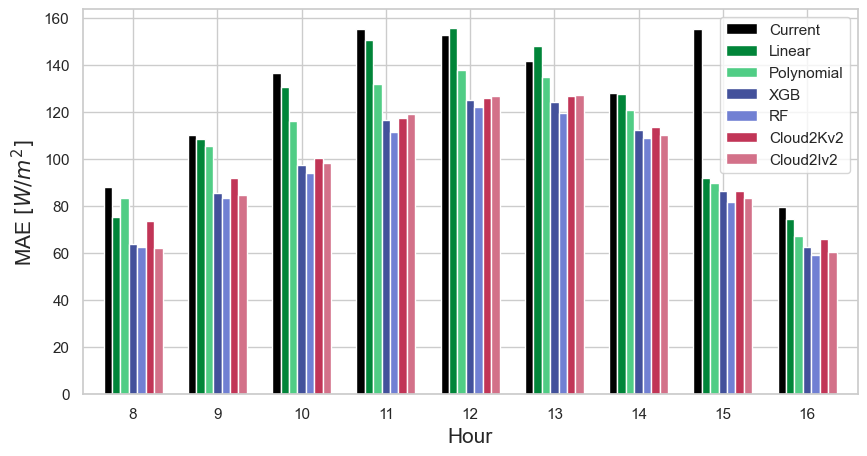

In [44]:
name_model = ['model_v2','linear','poly','yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
q = group_table(compare, name_model, base = 'I').drop(columns=['I'])
sns.set(style="whitegrid")
color0 = '#000000'
color1 = '#43519B'
color2 = '#7180D3'
color3='#C13557'
color4 = '#D37189'
color5 = '#018539'
color6 = '#50CD85'
label = ['Current','Linear','Polynomial','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
ax= q.plot(x='Datetime', y=name_model, kind="bar",color=[color0,color5,color6,color1,color2,color3,color4],label=label,rot=0,width=0.7,figsize=(10,5))

plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'MAE $[W/m^2]$',fontsize=15)
#save_figure('MAE_HOURLY_P2P')

In [45]:
eva_table(compare, name_model, base='I')

,Overall MAE,Overall RMSE,MAE at noon,RMSE at noon,MAE at non-noon,RMSE at non-noon
model_v2,130.460362,171.813157,144.422812,191.462270,117.920657,152.016686
linear,120.740145,155.437749,145.542560,182.472813,98.465044,126.318416
poly,112.151278,150.551407,131.294174,176.733628,94.959004,122.351320
yXGB,99.226824,139.325925,119.596754,165.462601,80.932548,110.712644
yRF,95.706232,134.288641,115.524520,159.573469,77.907386,106.584771
I_Cloud2Kv2,102.216087,145.012010,120.866539,172.298008,85.466078,115.119969
I_Cloud2Iv2,99.071673,143.743172,120.709822,171.647827,79.638407,112.951377


In [46]:
name_model = ['linear','poly','yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']

df = group_table(dfcm, name_model, base='I', by=[dfcm.index.date,'site_name'])
df.rename(columns={'level_0':'date'}, inplace=True)
df['meanMAE4model'] = (df.yXGB+df.yRF+df.I_Cloud2Kv2+df.I_Cloud2Iv2)/4
df['n_data_point'] = dfcm[['site_name','I']].groupby(by=[dfcm.index.date,'site_name']).count().I.values

df_bad = df[df.n_data_point==17].nlargest(3,'meanMAE4model')
df_best = df[df.n_data_point==17].nsmallest(3,'meanMAE4model')

bad_date = [str(d) for d in df_bad.date.to_list()]
best_date = [str(d) for d in df_best.date.to_list()]
bad_site = df_bad.site_name.to_list()
best_site = df_best.site_name.to_list()

C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2246504791.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2246504791.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=label,loc="upper right",fontsize=11);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2246504791.py:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize='17',bbox_to_anchor=(1.4, 0.7), borderaxespad=0);


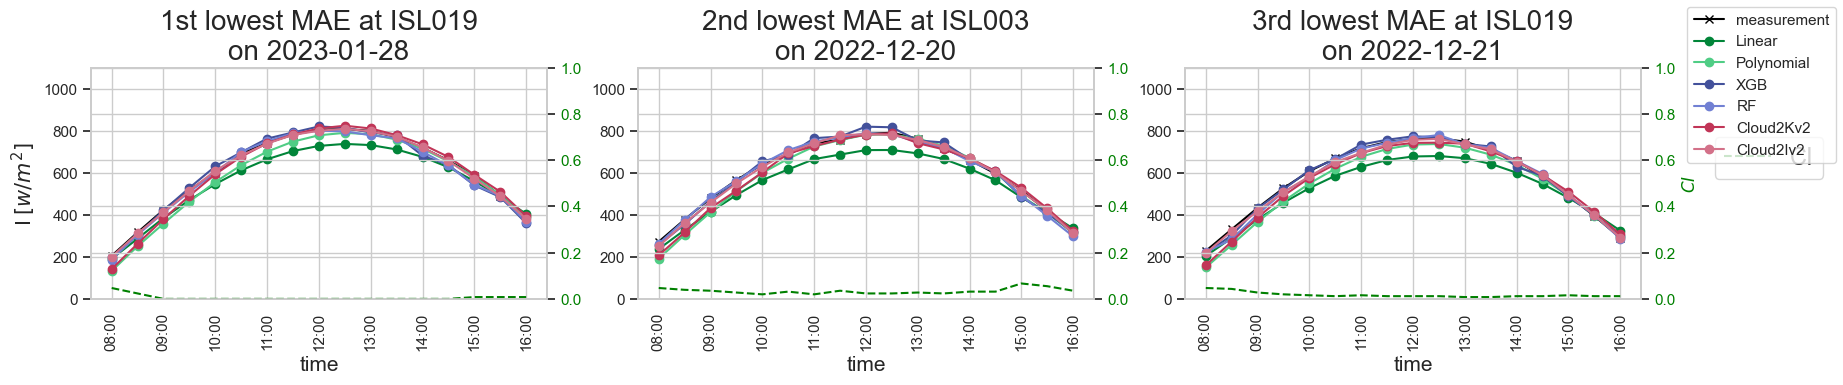

In [48]:
i= 1 # rank

label = ['measurement','Linear','Polynomial','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
color=[color5, color6, color1,color2,color3,color4]
filenames = {'highest':'pp_highest','lowest':'pp_lowest'}

rank = ['highest','lowest']
site = {'highest':bad_site,'lowest':best_site}
date = {'highest':bad_date,'lowest':best_date}
ggg = ['1st ','2nd ','3rd ']
####################################
fig,ax=plt.subplots(1,3, figsize=(20,3))
for k in range(3):
    plt.subplot(1,3,k+1)
    ee1 = dfcm[dfcm.site_name==site[rank[i]][k]].loc[date[rank[i]][k]]
    
    l1=plt.plot(ee1.I,'-x',color='black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]],'-o',color=color[e])
    
    plt.xlabel('time',fontsize=15)
    if k ==0:
        plt.ylabel(r'I $[w/m^2]$',fontsize=15)
    plt.xticks(rotation = 'vertical');
    plt.title(ggg[k]+rank[i]+' MAE at '+site[rank[i]][k]+ '\non '+date[rank[i]][k],fontsize=20)
    ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
    ax[k].set_ylim(0,1100)
 
    ax2 = ax[k].twinx()
    if k ==2:
        ax2.set_ylabel(r'$CI$', color='green')  
    lns2 = ax2.plot(ee1['CI0'], '--',color='green',label='CI')
    ax2.tick_params(axis='y', labelcolor='green');
    ax2.set_ylim(0,1)

fig.legend(l1, labels=label,loc="upper right",fontsize=11);
ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize='17',bbox_to_anchor=(1.4, 0.7), borderaxespad=0);
#save_figure(filenames[rank[i]])

In [49]:
name_model = ['yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']

df = group_table(dfov, name_model, base='I', by=[dfov.index.date,'site_name'])
df.rename(columns={'level_0':'date'}, inplace=True)
df['meanMAE4model'] = (df.yXGB+df.yRF+df.I_Cloud2Kv2+df.I_Cloud2Iv2)/4
df['n_data_point'] = dfov[['site_name','I']].groupby(by=[dfov.index.date,'site_name']).count().I.values

df_bad = df[df.n_data_point>=14].nlargest(6,'meanMAE4model')
df_best = df[df.n_data_point>=14].nsmallest(6,'meanMAE4model')

bad_date = [str(d) for d in df_bad.date.to_list()]
best_date = [str(d) for d in df_best.date.to_list()]
bad_site = df_bad.site_name.to_list()
best_site = df_best.site_name.to_list()

C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2129141213.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2129141213.py:37: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=label,loc="upper right",fontsize=11);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2129141213.py:38: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize='17',bbox_to_anchor=(1.4, 0.7), borderaxespad=0);


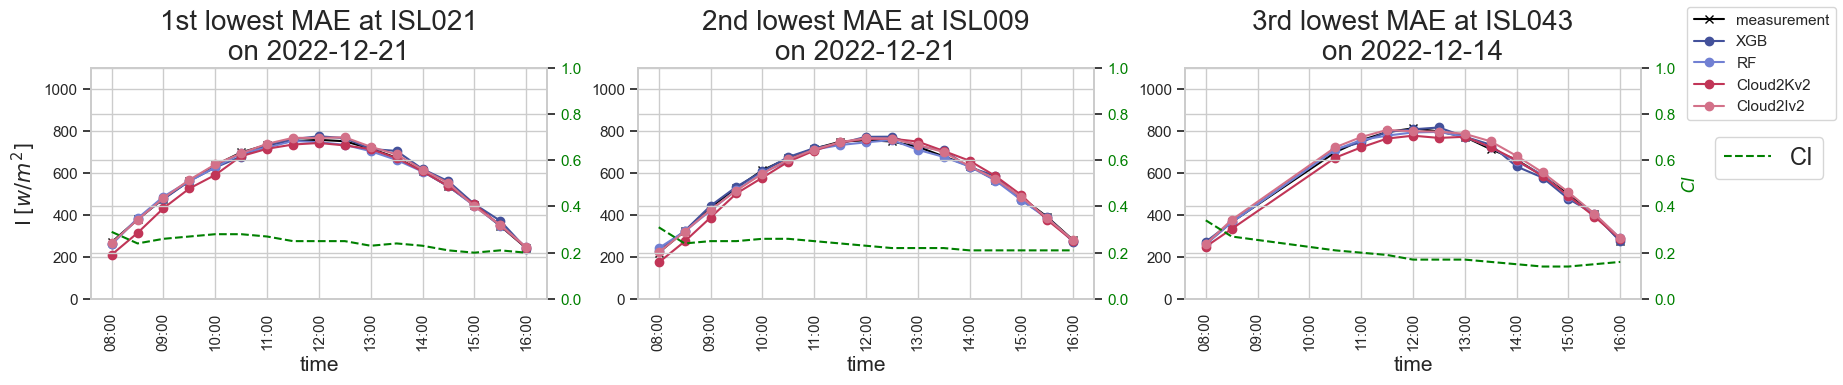

In [50]:
i=1  # rank

nrow=1
label = ['measurement','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
color=[color1,color2,color3,color4]
filenames = {'highest':'pp_highest_ov','lowest':'pp_lowest_ov'}

rank = ['highest','lowest']
site = {'highest':bad_site,'lowest':best_site}
date = {'highest':bad_date,'lowest':best_date}

ggg = ['1st ','2nd ','3rd ','4th ', '5th ','6 th ']
####################################
fig,ax=plt.subplots(nrow,3, figsize=(20,3))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow,3,k+1)
    ee1 = dfov[dfov.site_name==site[rank[i]][k]].loc[date[rank[i]][k]]
    ee1['CI0'] = ee1['CI0'].round(2)
    l1=plt.plot(ee1.I,'-x',color='black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]],'-o',color=color[e])
    
    plt.xlabel('time',fontsize=15)
    if k ==0:
        plt.ylabel(r'I $[w/m^2]$',fontsize=15)
    plt.xticks(rotation = 'vertical');
    plt.title(ggg[k]+rank[i]+' MAE at '+site[rank[i]][k]+ '\non '+date[rank[i]][k],fontsize=20)
    ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
    ax[k].set_ylim(0,1100)
    ax2 = ax[k].twinx()
    if k ==2:
        ax2.set_ylabel(r'$CI$', color='green')  
    lns2 = ax2.plot(ee1['CI0'], '--',color='green',label='CI')
    ax2.tick_params(axis='y', labelcolor='green');
    ax2.set_ylim(0,1)
fig.legend(l1, labels=label,loc="upper right",fontsize=11);
ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize='17',bbox_to_anchor=(1.4, 0.7), borderaxespad=0);

#save_figure(filenames[rank[i]])

In [51]:
name_model = ['model_v2','yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
compare = pd.merge(df_phase2,dfov,on=['Datetime','site_name'],how='inner')
eva_table(compare, name_model, base='I')

,Overall MAE,Overall RMSE,MAE at noon,RMSE at noon,MAE at non-noon,RMSE at non-noon
model_v2,132.986074,175.201380,148.316876,196.601590,119.307875,153.611718
yXGB,87.855136,126.299600,103.668923,147.200171,73.746015,104.170452
yRF,84.541236,122.003880,100.234226,142.789756,70.539890,99.871346
I_Cloud2Kv2,89.072010,129.052661,104.215682,151.284034,75.560769,105.328698
I_Cloud2Iv2,83.151244,124.857881,100.178517,148.229562,67.959447,99.473556


Text(0, 0.5, 'MAE $[W/m^2]$')

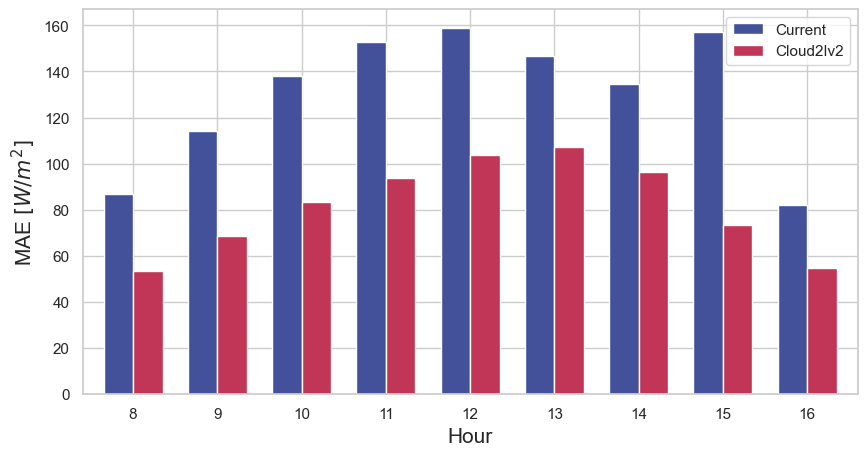

In [52]:
name_model = ['model_v2', 'I_Cloud2Iv2']
q = group_table(compare, name_model, base = 'I').drop(columns=['I'])
sns.set(style="whitegrid")
color0 = '#000000'
color1 = '#43519B'
color2 = '#7180D3'
color3='#C13557'
color4 = '#D37189'
color5 = '#018539'
color6 = '#50CD85'
label = ['Current', 'Cloud2Iv2']
ax= q.plot(x='Datetime', y=name_model, kind="bar",color=[color1,color3],label=label,rot=0,width=0.7,figsize=(10,5))

plt.xlabel('Hour',fontsize=15)
plt.ylabel(r'MAE $[W/m^2]$',fontsize=15)
#save_figure('MAE_HOURLY_P2P_one')

# CLOUD IMAGE PROBLEM

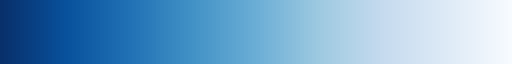

In [53]:
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
cm.get_cmap('Blues_r', 128)

In [55]:
METFOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\metadata'

filename = 'plant_metadata.csv'
dfplant = pd.read_csv(os.path.join(METFOLDER, filename))
dfplant[dfplant.site_name=='ISL018']

,Unnamed: 0,site_name,location_id,site_capacity,point_p,point_i,lat,lng,tile_id,alt,row,col
17,17,ISL018,26,648.0,1313.0,1314.0,16.766,103.6491,13221023323103,165.0,673,1038


In [56]:
name_model = ['yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']
q0 = group_table(dfcm, name_model, base = 'I', score = 'MAE', by = [dfcm.index.date, 'site_name']).drop(columns=['I'])
count_sample =  dfcm.groupby(by = [dfcm.index.date, 'site_name']).count().reset_index()
q0['n'] = pd.merge(q0, count_sample, on = ['level_0', 'site_name']).I
q1 = group_table(dfov, name_model, base = 'I', score = 'MAE', by = [dfov.index.date, 'site_name']).drop(columns=['I'])
q = pd.merge(q0, q1, on = ['level_0', 'site_name'])
q['diff'] = abs(q.I_Cloud2Iv2_x - q.I_Cloud2Iv2_y)
q = q[q.n>=16]
q= q.sort_values('diff', ascending  = False).head(4)
date = [str(d) for d in q.level_0.to_list()]
site = q.site_name.to_list()

C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2624490421.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2624490421.py:33: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=label,loc="upper right",fontsize=15);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2624490421.py:35: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize=20,bbox_to_anchor=(1.5, 0.5), borderaxespad=0);


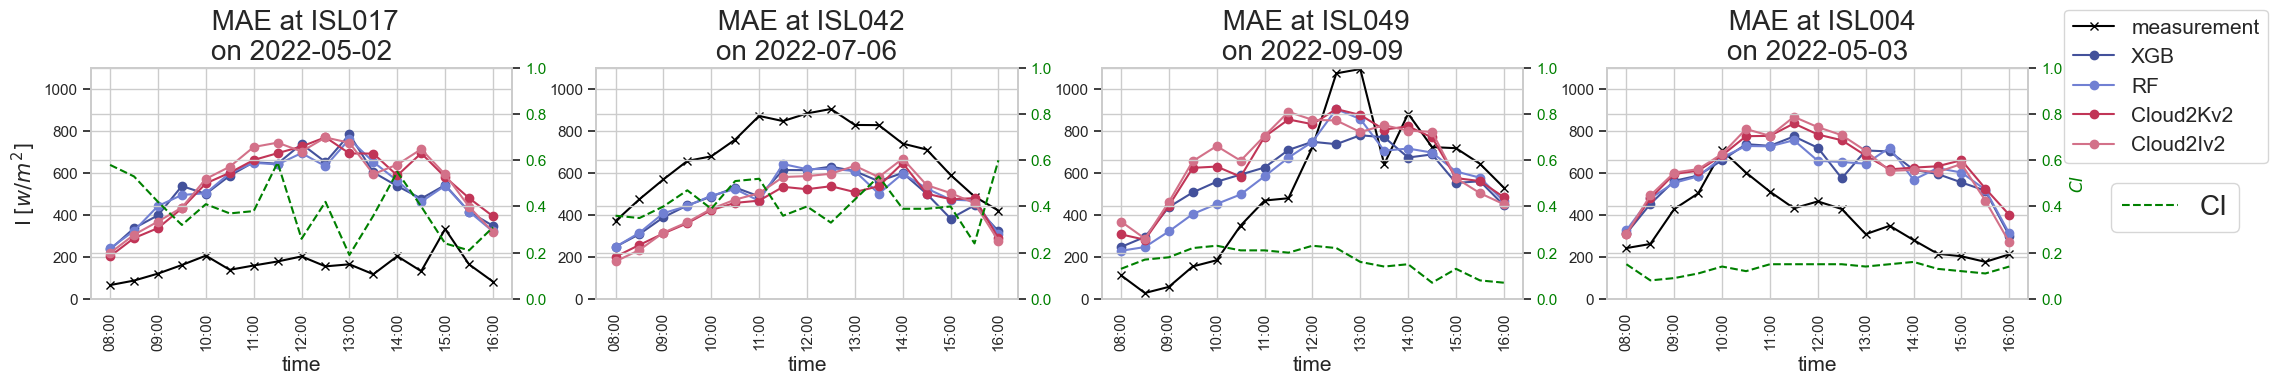

In [57]:
nrow=1
ncol = 4
label = ['measurement','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
name_model = ['yXGB', 'yRF', 'I_Cloud2Kv2', 'I_Cloud2Iv2']

color=[color1,color2,color3,color4]

####################################
fig,ax=plt.subplots(nrow,ncol, figsize=(25,3))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow,ncol,k+1)
    ee1 = dfcm[dfcm.site_name==site[k]].loc[date[k]]
    ee1['CI0'] = ee1['CI0'].round(2)
    l1=plt.plot(ee1.I,'-x',color='black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]],'-o',color=color[e])
    
    plt.xlabel('time',fontsize=15)
    if k ==0:
        plt.ylabel(r'I $[w/m^2]$',fontsize=15)
    plt.xticks(rotation = 'vertical');
    plt.title(' MAE at '+site[k]+ '\non '+date[k],fontsize=20)
    ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
    ax[k].set_ylim(0,1100)
    ax2 = ax[k].twinx()
    if k ==ncol-1:
        ax2.set_ylabel(r'$CI$', color='green')  
    lns2 = ax2.plot(ee1['CI0'], '--',color='green',label='CI')
    ax2.tick_params(axis='y', labelcolor='green');
    ax2.set_ylim(0,1)
    
fig.legend(l1, labels=label,loc="upper right",fontsize=15);

ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize=20,bbox_to_anchor=(1.5, 0.5), borderaxespad=0);
#save_figure('cm_bad')

C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\1587948504.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\1587948504.py:29: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=label,loc="upper right",fontsize=15);
C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\1587948504.py:30: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize=20,bbox_to_anchor=(1.5, 0.5), borderaxespad=0);


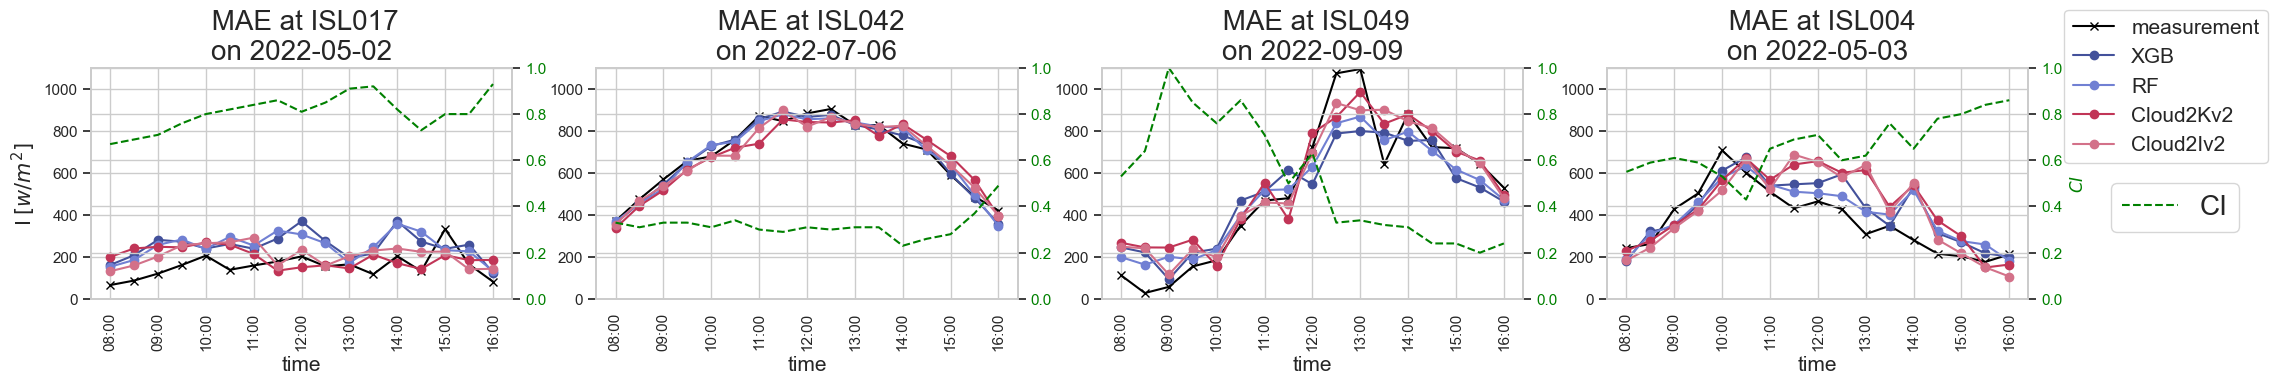

In [58]:
label = ['measurement','XGB','RF','Cloud2Kv2', 'Cloud2Iv2']
color=[color1,color2,color3,color4]

####################################
fig,ax=plt.subplots(nrow,ncol, figsize=(25,3))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow,ncol,k+1)
    ee1 = dfov[dfov.site_name==site[k]].loc[date[k]]
    ee1['CI0'] = ee1['CI0'].round(2)
    l1=plt.plot(ee1.I,'-x',color='black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]],'-o',color=color[e])
    
    plt.xlabel('time',fontsize=15)
    if k ==0:
        plt.ylabel(r'I $[w/m^2]$',fontsize=15)
    plt.xticks(rotation = 'vertical');
    plt.title(' MAE at '+site[k]+ '\non '+date[k],fontsize=20)
    ax[k].set_xticklabels(['08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00']);
    ax[k].set_ylim(0,1100)
    if True:
        ax2 = ax[k].twinx()
        if k == ncol-1:
            ax2.set_ylabel(r'$CI$', color='green')  
        lns2 = ax2.plot(ee1['CI0'], '--',color='green',label='CI')
        ax2.tick_params(axis='y', labelcolor='green');
        ax2.set_ylim(0,1)
fig.legend(l1, labels=label,loc="upper right",fontsize=15);
ax2.legend(lns2, labels=['CI'],loc="upper right",fontsize=20,bbox_to_anchor=(1.5, 0.5), borderaxespad=0);
#save_figure('ov_better')

In [59]:
EXIMFOLDER= 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\example_im\\ex_issue'
CMPATH = os.path.join(EXIMFOLDER,'cm')
OVPATH = os.path.join(EXIMFOLDER,'ov')
CM_filenames = os.listdir(CMPATH)
OV_filenames = os.listdir(OVPATH)
CM_filenames

['himawari_ahi_ir_cloud_day_202205020500.tif',
 'himawari_ahi_ir_cloud_day_202206160500.tif',
 'himawari_ahi_ir_cloud_day_202302040300.tif',
 'himawari_ahi_ir_cloud_day_302206030400.tif']

In [60]:
date = '2022-05-02'
site = 'ISL017'
row, col = 777, 1006
w = 16
I = Image.open(os.path.join(CMPATH, CM_filenames[0]))
imarray_cm = np.array(I)
imarray_cm0 = imarray_cm[row-w:row+w,col-w:col+w,0]

I = Image.open(os.path.join(OVPATH, OV_filenames[0]))
imarray_ov = np.array(I)
imarray_ov0 = imarray_ov[row-w:row+w,col-w:col+w,0]

Text(0.5, 0.95, 'Cloud image on 2022-05-02 and the red point is position of ISL017 station')

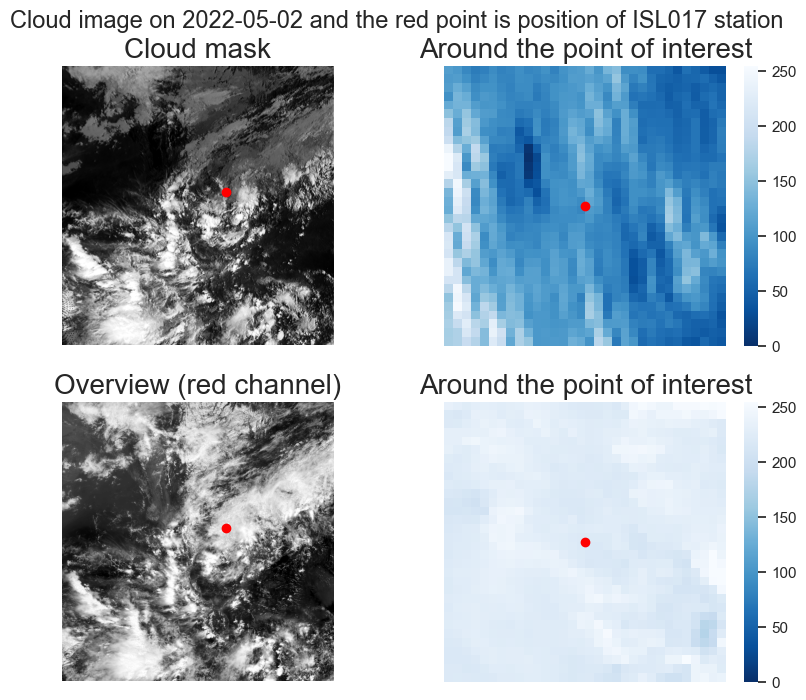

In [61]:
fig,ax=plt.subplots(2,2, figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(imarray_cm[:,:,0],cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Cloud mask', fontsize=20)

plt.subplot(2,2,2)
sns.heatmap(imarray_cm0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

plt.subplot(2,2,3)
plt.imshow(imarray_ov[:,:,0], cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Overview (red channel)', fontsize=20)

plt.subplot(2,2,4)
sns.heatmap(imarray_ov0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

fig.suptitle('Cloud image on {} and the red point is position of {} station'.format(date,site), y = 0.95, fontsize = 17)
#save_figure('correct_ov')

In [62]:
#1112/789
date = '2022-06-16'
site = 'ISL002'
row, col = 849, 850
w = 16
I = Image.open(os.path.join(CMPATH, CM_filenames[1]))
imarray_cm = np.array(I)
imarray_cm0 = imarray_cm[row-w:row+w,col-w:col+w,0]

I = Image.open(os.path.join(OVPATH, OV_filenames[1]))
imarray_ov = np.array(I)
imarray_ov0 = imarray_ov[row-w:row+w,col-w:col+w,0]

Text(0.5, 0.95, 'Cloud image on 2022-06-16 and the red point is position of ISL002 station')

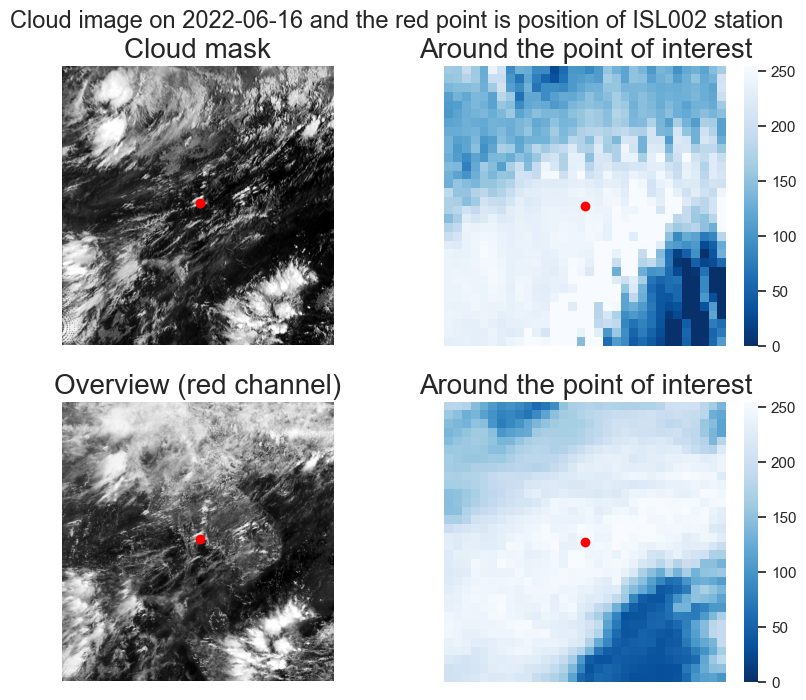

In [63]:
fig,ax=plt.subplots(2,2, figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(imarray_cm[:,:,0],cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Cloud mask', fontsize=20)

plt.subplot(2,2,2)
sns.heatmap(imarray_cm0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

plt.subplot(2,2,3)
plt.imshow(imarray_ov[:,:,0], cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Overview (red channel)', fontsize=20)

plt.subplot(2,2,4)
sns.heatmap(imarray_ov0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

fig.suptitle('Cloud image on {} and the red point is position of {} station'.format(date,site), y = 0.95, fontsize = 17)
#save_figure('wrong_both')

In [64]:
date = '2023-02-04'
site = 'ISL018'
row, col = 673, 1038
w = 16
I = Image.open(os.path.join(CMPATH, CM_filenames[2]))
imarray_cm = np.array(I)
imarray_cm0 = imarray_cm[row-w:row+w,col-w:col+w,0]

I = Image.open(os.path.join(OVPATH, OV_filenames[2]))
imarray_ov = np.array(I)
imarray_ov0 = imarray_ov[row-w:row+w,col-w:col+w,0]

Text(0.5, 0.95, 'Cloud image on 2023-02-04 and the red point is position of ISL018 station')

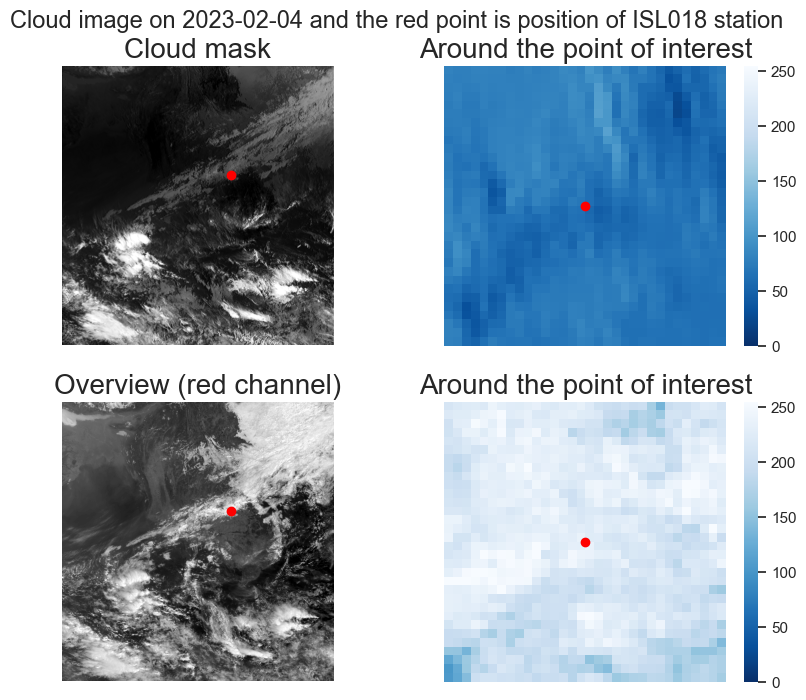

In [65]:
fig,ax=plt.subplots(2,2, figsize=(10,8))

plt.subplot(2,2,1)
plt.imshow(imarray_cm[:,:,0],cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Cloud mask', fontsize=20)

plt.subplot(2,2,2)
sns.heatmap(imarray_cm0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

plt.subplot(2,2,3)
plt.imshow(imarray_ov[:,:,0], cmap='gray')
plt.axis('off')
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Overview (red channel)', fontsize=20)

plt.subplot(2,2,4)
sns.heatmap(imarray_ov0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

fig.suptitle('Cloud image on {} and the red point is position of {} station'.format(date,site), y = 0.95, fontsize = 17)
#save_figure('wrong_ov')

In [66]:
#1112/789
date = '2022-06-03'
site = 'ISL002'
row, col = 849, 850
w = 16
I = Image.open(os.path.join(CMPATH, CM_filenames[3]))
imarray_cm = np.array(I)
imarray_cm0 = imarray_cm[row-w:row+w,col-w:col+w,0]

I = Image.open(os.path.join(OVPATH, OV_filenames[3]))
imarray_ov = np.array(I)
imarray_ov0 = imarray_ov[row-w:row+w,col-w:col+w,0]

Text(0.5, 0.95, 'Cloud image on 2022-06-03 and the red point is position of ISL002 station')

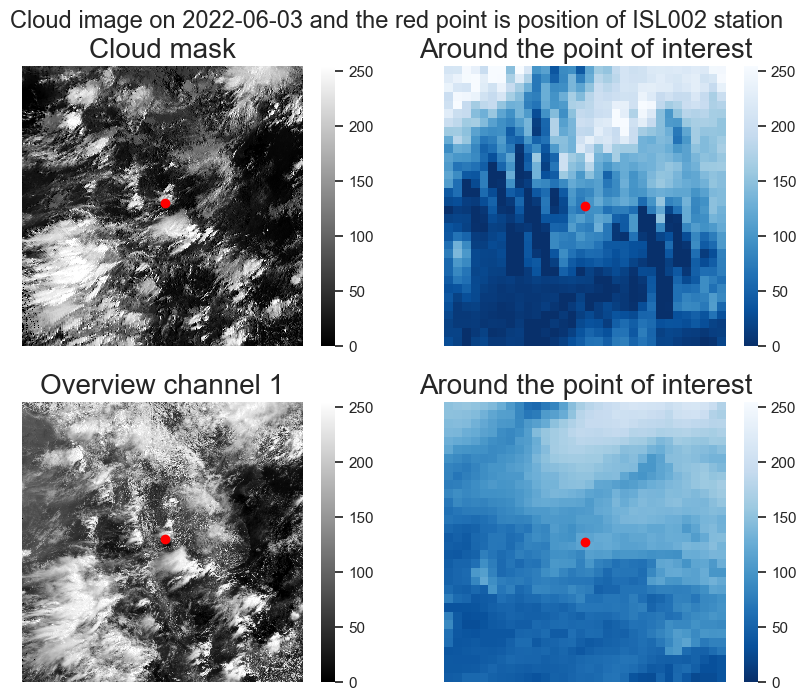

In [67]:
fig,ax=plt.subplots(2,2, figsize=(10,8))

plt.subplot(2,2,1)
sns.heatmap(imarray_cm[:,:,0], fmt=".2f",cmap='gray',xticklabels=False,yticklabels=False)
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Cloud mask', fontsize=20)

plt.subplot(2,2,2)
sns.heatmap(imarray_cm0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

plt.subplot(2,2,3)
sns.heatmap(imarray_ov[:,:,0], fmt=".2f",cmap='gray',xticklabels=False,yticklabels=False)
plt.plot(col, row, color = 'red', marker = 'o')
plt.title('Overview channel 1', fontsize=20)

plt.subplot(2,2,4)
sns.heatmap(imarray_ov0, fmt=".2f",cmap='Blues_r',xticklabels=False,yticklabels=False,vmin=0, vmax=255)
plt.title('Around the point of interest', fontsize=20)
plt.plot(w,w, color = 'red', marker = 'o')

fig.suptitle('Cloud image on {} and the red point is position of {} station'.format(date,site), y = 0.95, fontsize = 17)

# The best model validation

In [77]:
IHAT_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\estimation_irradiance'
DATA_FOLDER = 'C:\\Users\\Tee\\senior_project\\src\\Data_visualization\\dataset'
OV_DATA = 'DATASET_ch1_overview.csv'
CM_DATA = 'separated_DATASET_cloudmask.csv'
OVCNN_FILE = 'Ihat_2layerCNN.csv'
CMCNN_FILE = 'Ihat_1layerCNN.csv'

In [78]:
df_ov_cnn = pd.read_csv(os.path.join(IHAT_FOLDER,OVCNN_FILE),parse_dates=['datetime'],index_col='datetime')
df_ov_cnn.index.name = 'Datetime'
df_ov_cnn.index = df_ov_cnn.index.tz_localize('Asia/Bangkok')
df_ov_cnn.rename(columns = {'site':'site_name'}, inplace = True)

df_cm_cnn = pd.read_csv(os.path.join(IHAT_FOLDER,CMCNN_FILE),parse_dates=['datetime'],index_col='datetime')
df_cm_cnn.index.name = 'Datetime'
df_cm_cnn.index = df_cm_cnn.index.tz_localize('Asia/Bangkok')
df_cm_cnn.rename(columns = {'site':'site_name'}, inplace = True)

In [80]:
dz = pd.read_csv(os.path.join(DATA_FOLDER,OV_DATA),parse_dates=['Datetime'],index_col='Datetime')
dy = pd.read_csv(os.path.join(DATA_FOLDER,CM_DATA),parse_dates=['Datetime'],index_col='Datetime')

In [84]:
df_cm_cnn = df_cm_cnn.merge(dy[['site_name', 'k_bar']], on = ['Datetime', 'site_name'], how = 'inner')
df_ov_cnn = df_ov_cnn.merge(dz[['site_name', 'k_bar']], on = ['Datetime', 'site_name'], how = 'inner')

C:\Users\Tee\AppData\Local\Temp\ipykernel_10632\2494194663.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(ticks_label)


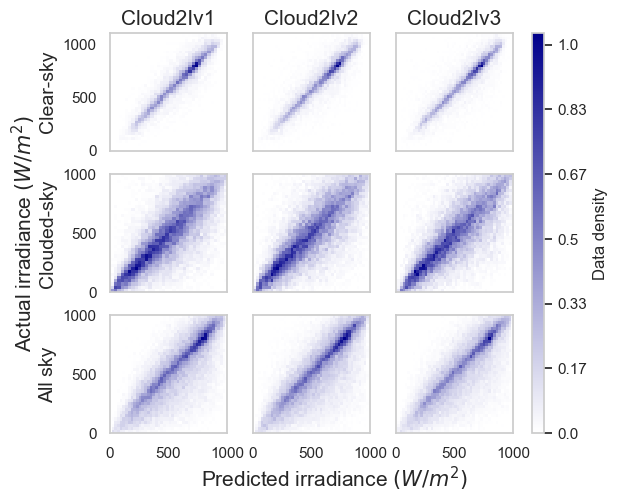

In [85]:
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap


sns.set(style= 'whitegrid')
name = ['Cloud2Iv1', 'Cloud2Iv2', 'Cloud2Iv3']
dcloud, dclear = sep_clear(df_ov_cnn)
base = 'I'
name_models = ['I_Cloud2Iv1', 'I_Cloud2Iv2', 'I_Cloud2Iv3']
fig,ax=plt.subplots(3,3, figsize=(6,5),edgecolor='black')
bins = 45
cmap = LinearSegmentedColormap.from_list('', ['white', 'darkblue'])

for i in range(len(name_models)):

    plt.subplot(3,3,i+1,aspect='equal')
    plt.hist2d(dclear[name_models[i]],dclear[base], bins=bins, cmap = cmap,)
    plt.xlim(0,1100);plt.ylim(0,1100)
    plt.xticks([])
    plt.title('{}'.format(name[i]), fontsize = 15)

    if i ==0:
        plt.ylabel('Clear-sky',fontsize = 14)
    if i != 0:
        plt.yticks([])
        
    plt.subplot(3,3,i+4,aspect='equal')
    plt.hist2d(dcloud[name_models[i]],dcloud[base], bins=bins, cmap = cmap, )
    plt.xlim(0,1000);plt.ylim(0,1000)
    plt.xticks([])

    if i ==0:
        plt.ylabel('Clouded-sky', fontsize = 14)

    if i != 0:
        plt.yticks([])

        
    plt.subplot(3,3,i+7,aspect='equal')
    plt.hist2d(df_cm_cnn[name_models[i]],df_cm_cnn[base], bins=bins, cmap = cmap)
    plt.xlim(0,1000);plt.ylim(0,1000)
    if i == 0 :
        plt.ylabel('All sky'.format(name[i]),fontsize = 14)

    if i != 0:
        plt.yticks([])
        
fig.supxlabel('Predicted irradiance $(W/m^{2})$', fontsize = 15,y = -0.02)
fig.supylabel('Actual irradiance $(W/m^{2})$', fontsize = 15,x=-0.04)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.1, 0.02, 0.8])
cbar = plt.colorbar(cax=cax)
label = cbar.get_ticks()[:-1]
ticks_label = [round(d,2) for d in (label/max(label))]
cbar.set_ticklabels(ticks_label)
cbar.set_label('Data density')
#save_figure('scatter_actual_predicted')

In [88]:
print('# of samples for each level of k')
print('type klow kmedium khigh')
nklow, nkmed, nkhigh = count_sample_k(dy)
print('CM',nklow, nkmed, nkhigh)
nklow, nkmed, nkhigh = count_sample_k(dz)
print('OV',nklow, nkmed, nkhigh)

# of samples for each level of k
type klow kmedium khigh
CM 5228 43518 207755
OV 4643 39471 180013


In [89]:
dz.index = dz.index.tz_convert('Asia/Bangkok')

In [90]:
#hard_time 9.30-15.00
#easy_time 8.00-10.00 & 14.00-16.00

dfov_clr = df_ov_cnn[df_ov_cnn.k_bar >= 0.9]
dfov_cloud = df_ov_cnn[df_ov_cnn.k_bar < 0.9]

df_hard_time = df_ov_cnn.between_time('9:30','15:00')
df_easy_time = pd.concat([df_ov_cnn.between_time('08:00','10:00'),df_ov_cnn.between_time('14:00','16:00')])

df_hard_clr = df_hard_time[df_hard_time.k_bar>=0.9]
df_hard_cloud = df_hard_time[df_hard_time.k_bar<0.9]

df_easy_clr =  df_easy_time[df_easy_time.k_bar>=0.9]
df_easy_cloud = df_easy_time[df_easy_time.k_bar<0.9]

In [91]:
dlist = [df_ov_cnn, dfov_clr, dfov_cloud, df_hard_time, df_hard_clr, df_hard_cloud, df_easy_time, df_easy_clr, df_easy_cloud]

In [92]:
name_model = 'I_Cloud2Iv1'
base = 'I'
dv1 = pd.DataFrame()
for i in range(len(dlist)):
    dv1 = pd.concat([dv1, single_model_eva(dlist[i], name_model, base = 'I')])
dv1.index = ['ALL','ALLCLR','ALLCLOUD','HALL','HCLR','HCLOUD','EALL', 'ECLR', 'ECLOUD']
dv1

,MBE,NMBE,MAE,NMAE,RMSE,NRMSE,Rsq,i_mean,SD
ALL,5.060674,0.927653,99.733202,18.281707,145.797226,26.725524,0.679905,545.535515,26.709420
ALLCLR,-7.828551,-1.209221,64.050535,9.893434,99.346293,15.345321,0.791316,647.404453,15.297603
ALLCLOUD,12.615606,2.596735,120.648355,24.833669,167.126684,34.400542,0.589021,485.825731,34.302394
HALL,6.430320,1.028262,111.509053,17.831224,160.411985,25.651209,0.577931,625.358391,25.630591
HCLR,-7.954244,-1.062923,68.611622,9.168548,106.048582,14.171236,0.558051,748.336854,14.131317
HCLOUD,14.761187,2.663825,136.353242,24.606502,184.719917,33.334822,0.496034,554.135009,33.228216
EALL,3.797688,0.853343,86.435245,19.422066,125.654276,28.234612,0.661180,445.036312,28.221714
ECLR,-9.171167,-1.737671,60.806549,11.521084,92.894359,17.600797,0.744548,527.784966,17.514809
ECLOUD,11.403352,2.875946,101.465350,25.589745,141.378248,35.655850,0.581382,396.507857,35.539676


In [94]:
name_model = 'I_Cloud2Iv2'
base = 'I'
dv2 = pd.DataFrame()
for i in range(len(dlist)):
    dv2 = pd.concat([dv2, single_model_eva(dlist[i], name_model, base = 'I')])
dv2.index = ['ALL','ACR','ACD','HAL','HCR','HCD','EAL', 'ECR', 'ECD']
dv2

,MBE,NMBE,MAE,NMAE,RMSE,NRMSE,Rsq,i_mean,SD
ALL,-0.642075,-0.117696,101.417661,18.590478,148.903979,27.295011,0.666118,545.535515,27.294757
ACR,-13.651882,-2.108710,65.892094,10.177887,102.113846,15.772806,0.779527,647.404453,15.631210
ACD,6.983534,1.437457,122.240731,25.161436,170.460374,35.086732,0.572462,485.825731,35.057275
HAL,0.538932,0.086180,113.635047,18.171188,164.209120,26.258402,0.557713,625.358391,26.258260
HCR,-13.632796,-1.821746,70.638370,9.439381,109.265552,14.601119,0.530832,748.336854,14.487026
HCD,8.746536,1.578412,138.536713,25.000534,188.856569,34.081328,0.473209,554.135009,34.044758
EAL,-1.339882,-0.301072,87.861999,19.742658,128.264845,28.821209,0.646955,445.036312,28.819636
ECR,-14.813781,-2.806783,62.720169,11.883660,95.661274,18.125047,0.729104,527.784966,17.906404
ECD,6.561969,1.654940,102.606579,25.877565,143.991195,36.314840,0.565766,396.507857,36.277111


In [95]:
name_model = 'I_Cloud2Iv3'
base = 'I'
dv3 = pd.DataFrame()
for i in range(len(dlist)):
    dv3 = pd.concat([dv3, single_model_eva(dlist[i], name_model, base = 'I')])
dv3.index = ['ALL','ALLCLR','ALLCLOUD','HALL','HCLR','HCLOUD','EALL', 'ECLR', 'ECLOUD']
dv3

,MBE,NMBE,MAE,NMAE,RMSE,NRMSE,Rsq,i_mean,SD
ALL,13.152910,2.411009,100.394835,18.402988,147.980969,27.125818,0.670244,545.535515,27.018457
ALLCLR,-5.713668,-0.882550,62.879128,9.712496,100.399005,15.507926,0.786870,647.404453,15.482793
ALLCLOUD,24.211426,4.983562,122.384410,25.191010,169.781171,34.946929,0.575862,485.825731,34.589766
HALL,14.791309,2.365253,112.310802,17.959430,162.983506,26.062416,0.564291,625.358391,25.954867
HCLR,-5.672071,-0.757957,67.423154,9.009733,107.421141,14.354651,0.546537,748.336854,14.334626
HCLOUD,26.642743,4.807988,138.307631,24.959194,187.789799,33.888817,0.479144,554.135009,33.546016
EALL,12.038134,2.704978,87.668411,19.699159,128.535221,28.881963,0.645465,445.036312,28.755014
ECLR,-7.986317,-1.513176,60.258602,11.417264,94.951217,17.990512,0.733110,527.784966,17.926763
ECLOUD,23.781596,5.997762,103.743061,26.164188,144.647814,36.480441,0.561796,396.507857,35.984016


# Epoch visualization

In [96]:
DATA_FOLDER = 'epoch_cloud2I'
epoch_cloud2iv1 = 'hisc2Iv1.csv'
epoch_cloud2iv2 = 'hisc2Iv2.csv'
epoch_cloud2iv3 = 'hisc2Iv3.csv'

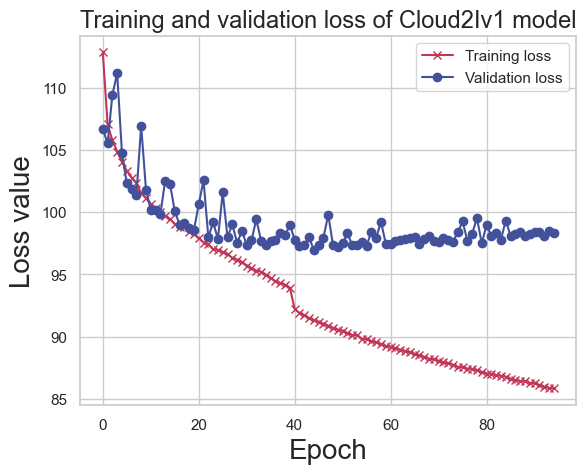

In [97]:
df = pd.read_csv(os.path.join(DATA_FOLDER,epoch_cloud2iv1))
plt.plot(df.epochs, df.loss, marker= 'x',color = color3)
plt.plot(df.epochs, df.val_loss,marker='o',color=color1)
plt.xlabel('Epoch',fontsize =20)
plt.ylabel('Loss value', fontsize = 20)
plt.title('Training and validation loss of Cloud2Iv1 model', fontsize= 17)
plt.legend(['Training loss', 'Validation loss'])
#save_figure('epoch_c2iv1')

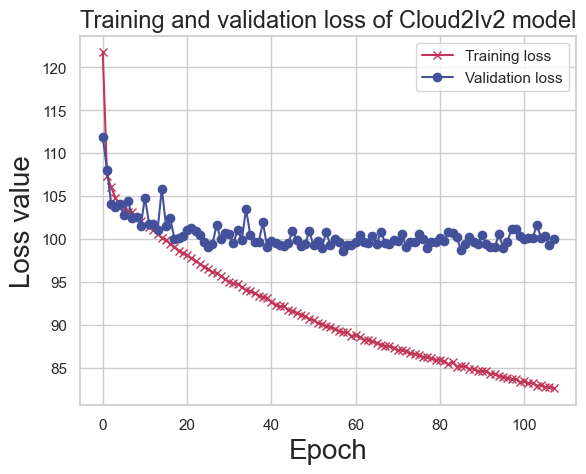

In [98]:
df = pd.read_csv(os.path.join(DATA_FOLDER,epoch_cloud2iv2))
plt.plot(df.epochs, df.loss, marker= 'x',color = color3)
plt.plot(df.epochs, df.val_loss,marker='o',color=color1)
plt.xlabel('Epoch',fontsize =20)
plt.ylabel('Loss value', fontsize = 20)
plt.title('Training and validation loss of Cloud2Iv2 model', fontsize= 17)
plt.legend(['Training loss', 'Validation loss'])
#save_figure('epoch_c2iv2')

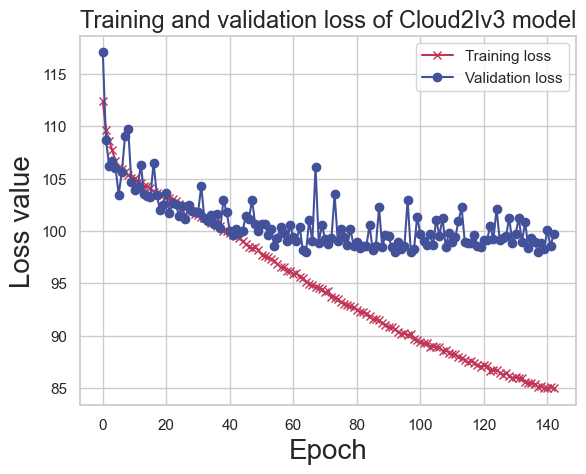

In [99]:
df = pd.read_csv(os.path.join(DATA_FOLDER,epoch_cloud2iv3))
plt.plot(df.epochs, df.loss, marker= 'x',color = color3)
plt.plot(df.epochs, df.val_loss,marker='o',color=color1)
plt.xlabel('Epoch',fontsize =20)
plt.ylabel('Loss value', fontsize = 20)
plt.title('Training and validation loss of Cloud2Iv3 model', fontsize= 17)
plt.legend(['Training loss', 'Validation loss'])
#save_figure('epoch_c2iv3')

# Avialabel cloud image checking

In [ ]:
dd1 = pd.read_csv('check_avialabel_cloudmask.csv', index_col=0).set_index('Datetime')
dd2 = pd.read_csv('check_avialabel_overview_chred.csv', index_col=0).set_index('Datetime')

dd1.index = pd.to_datetime(dd1.index)
dd2.index = pd.to_datetime(dd2.index)

dd = pd.merge(dd1,dd2,on='Datetime',how='inner')

In [ ]:
(dd.groupby(by=[dd.index.minute]).sum()/5124).plot(kind='bar',figsize = (8,5.5), ylim=[0,1], color=[color1,color3])
plt.legend(['cloudmask', 'overview'])
plt.xlabel('miniute')
plt.ylabel('$\dfrac{n}{N}$')
plt.title('Available cloud images')
plt.title('Available cloud images',fontsize= 15)
save_figure('available_cloud_im')

In [ ]:
dd1_lag = dd1.shift(periods=10,freq='T')
dd2_lag = dd2.shift(periods=10,freq='T')

dd1_lag = pd.merge(dd1,dd1_lag,on='Datetime',how='left').fillna(0)
dd2_lag = pd.merge(dd2,dd2_lag,on='Datetime',how='left').fillna(0)

dd1_lag['status'] = dd1_lag.status_x*dd1_lag.status_y
dd2_lag['status'] = dd2_lag.status_x*dd2_lag.status_y

dd1_lag = dd1_lag[['status']]
dd2_lag = dd2_lag[['status']]

dd_lag = pd.merge(dd1_lag,dd2_lag, on='Datetime', how ='inner')
dd_lag['status'] = dd_lag.status_x*dd_lag.status_y

(dd_lag.groupby(by=[dd_lag.index.minute]).sum()/5124).plot(kind='bar',figsize = (8,5.5), ylim=[0,1], color=[color1,color3,color0])
plt.legend(['cloudmask pair', 'overview pair','cloudmask & overview pair'])
plt.xlabel('miniute')
plt.title('Available cloud images',fontsize= 15)
save_figure('available_cloud_im_pair')